# Predicting SalePrice

## Objectives

Create and evaluate model to predict SalePrice of building

## Inputs:
* outputs/datasets/cleaned/test.parquet.gzip
* outputs/datasets/cleaned/train.parquet.gzip
* Conclusions from Feature Engineering jupyter_notebooks/04_Feature_Engineering.ipynb

## Outputs
* Train Set: Features and Target
* Test Set: Features and Target
* Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

you have set a new current directory


Confirm new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5'

## Loading Dataset

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
df.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,0,856,854.0,3.0,No,706,GLQ,150,0.0,548,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,3,961,NaN,NaN,No,216,ALQ,540,NaN,642,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Data Exploration
Before exploring data and doing transformations, as we decided earlier, we drop features:

In [5]:
drop_features = ['Unnamed: 0']
df.drop(columns=drop_features, inplace=True)

## Splitting to data and test dataframe

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='SalePrice')
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Machine Learning

### Pre-Transformations

In [7]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


class DatasetCleaner(BaseEstimator, TransformerMixin):
    """Custom dataset cleaner for pipeline integration.

    This class extends sklearn's TransformerMixin to allow for custom data
    cleaning during preprocessing pipelines. It handles various data cleaning 
    tasks such as filling missing values, adjusting feature inconsistencies, 
    and dropping unnecessary columns explicitly detailed within the transform 
    method, ensuring all features are appropriately processed.
    """

    def __init__(self):
        self.cleaning_descriptions_ = {}
        self.output_features_ = None  # Initialize output_features_

    def fit(self, X, y=None):
        # The fit method is not used for cleaning, it's just here for compatibility.
        return self

    def transform(self, X):
        """Apply a series of data cleaning steps to the dataframe.

        Args:
        X (pd.DataFrame): Input dataframe to be cleaned.

        Returns:
        pd.DataFrame: The cleaned dataframe.
        """
        X = X.copy()  # Work on a copy of the data to prevent changes to the original dataframe

        # Fill missing values with zero and convert to integers for numerical columns
        fill_zero_and_convert = ['1stFlrSF', '2ndFlrSF', 'GarageYrBlt']
        X[fill_zero_and_convert] = X[fill_zero_and_convert].fillna(0).astype(int)
        self.cleaning_descriptions_['fill_zero_and_convert'] = (
            f"Filled missing values in {fill_zero_and_convert} with 0 and converted to int."
        )

        # Swap values where '2ndFlrSF' is greater than '1stFlrSF'
        swap_idx = X['2ndFlrSF'] > X['1stFlrSF']
        X.loc[swap_idx, ['1stFlrSF', '2ndFlrSF']] = X.loc[swap_idx, ['2ndFlrSF', '1stFlrSF']].values
        self.cleaning_descriptions_['swap_flrsf'] = "Swapped values where '2ndFlrSF' is greater than '1stFlrSF'."

        # Correct garage years that are earlier than the house build year
        X.loc[X['GarageYrBlt'] < X['YearBuilt'], 'GarageYrBlt'] = X['YearBuilt']
        self.cleaning_descriptions_[
            'correct_garage_year'] = "Corrected garage years that are earlier than the house build year."

        return X

    def get_cleaning_descriptions(self):
        """Return the descriptions of the cleaning steps."""
        return self.cleaning_descriptions_

    def get_feature_names_out(self, input_features=None):
        """Return feature names for the cleaned features."""
        return self.output_features_

    def __repr__(self):
        cleaning_descriptions = "\n".join(
            [f"{step}: {desc}" for step, desc in self.cleaning_descriptions_.items()])
        return f"DatasetCleaner(cleaning_steps:\n{cleaning_descriptions})"


# Define custom FeatureCreator class
class FeatureCreator(BaseEstimator, TransformerMixin):
    """Custom feature creator for pipeline integration.

    This class extends sklearn's TransformerMixin to allow for custom feature
    creation during preprocessing pipelines. It handles various mathematical
    transformations and feature interactions explicitly detailed within the
    transform method, ensuring all features are appropriately processed and added.
    """

    def __init__(self):
        self.feature_creation_descriptions_ = {}
        self.output_features_ = None  # Initialize output_features_

    def fit(self, X, y=None):
        # The fit method is not used for adding features, it's just here for compatibility.
        return self

    def transform(self, X):
        """Apply a series of custom transformations to the dataframe.

        Args:
        X (pd.DataFrame): Input dataframe from which features are derived.

        Returns:
        pd.DataFrame: The dataframe with new features added.
        """
        X = X.copy()  # Work on a copy of the data to prevent changes to the original dataframe

        # New features descriptions to be presented in Pipeline
        self.feature_creation_descriptions_ = {
            'NF_TotalLivingArea': 'GrLivArea + 1stFlrSF + 2ndFlrSF',
            'NF_TotalLivingArea_mul_OverallQual': 'NF_TotalLivingArea * OverallQual',
            'NF_TotalLivingArea_mul_OverallCond': 'NF_TotalLivingArea * OverallCond',
            'NF_1stFlrSF_mul_OverallQual': '1stFlrSF * OverallQual',
        }
        # Numeric and Boolean feature interactions and transformations
        X['NF_TotalLivingArea'] = X['GrLivArea'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['NF_TotalLivingArea_mul_OverallQual'] = X['NF_TotalLivingArea'] * X['OverallQual']
        X['NF_TotalLivingArea_mul_OverallCond'] = X['NF_TotalLivingArea'] * X['OverallCond']
        X['NF_1stFlrSF_mul_OverallQual'] = X['1stFlrSF'] * X['OverallQual']

        # Drop columns not in the specified list of necessary features
        necessary_features = ['YearBuilt', 'GarageYrBlt', 'LotArea', 'NF_1stFlrSF_mul_OverallQual',
                              'NF_TotalLivingArea_mul_OverallCond', 'NF_TotalLivingArea_mul_OverallQual']
        X = X[necessary_features]

        self.output_features_ = X.columns.tolist()  # Set the output features
        return X

    def get_feature_names_out(self, input_features=None):
        """Return feature names for the transformed features."""
        return self.output_features_

    def __repr__(self):
        feature_descriptions = "\n".join(
            [f"{name}: {desc}" for name, desc in self.feature_creation_descriptions_.items()])
        return f"FeatureCreator(created_features:\n{feature_descriptions})"


# Pipeline setup
pre_feature_transformations = Pipeline(steps=[
    ('dataset_cleaner', DatasetCleaner()),  # Custom dataset cleaning
    ('feature_creator', FeatureCreator())  # Custom feature creation
])


### Transformations

In [8]:
from sklearn.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer, PowerTransformer

# Define the columns for each transformation type
yeo_johnson_features = ['LotArea', 'NF_TotalLivingArea_mul_OverallQual', 'NF_TotalLivingArea_mul_OverallCond',
                        'NF_1stFlrSF_mul_OverallQual']
power_features = ['GarageYrBlt']

# Create transformers for each group of features using feature_engine transformers
yeo_johnson_transformer = YeoJohnsonTransformer(variables=yeo_johnson_features)
power_transformer = PowerTransformer(variables=power_features, exp=0.5)

# Combine all transformers into a single pipeline
feature_transformer = Pipeline([
    ('yeo_johnson', yeo_johnson_transformer),
    ('power', power_transformer),
])

### Post Transformations

In [9]:
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# Define the columns for Winsorization
winsorize_features = ['LotArea', 'NF_TotalLivingArea_mul_OverallCond']

# Initialize the Winsorizer transformer
# We will apply Winsorizer to features from table in jupyter_notebooks/08_Feature_Engineering_hypothesis_3.ipynb
# The ones which gad high or above outliers
winsorize_transformer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=winsorize_features)

# Create the post-feature transformations pipeline
post_feature_transformer = Pipeline([
    ('winsorize', winsorize_transformer),
    ('standard_scaler', StandardScaler())
])

### Target Transformation

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin


class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Add a small constant to avoid log(0)
        return np.log1p(np.clip(X, 0, None))

    def inverse_transform(self, X):
        # Use expm1 for numerical stability, clip to avoid overflow
        return np.expm1(np.clip(X, None, 700))  # 700 is chosen to avoid overflow in expm1


# Create a pipeline for transforming the target variable
target_transformation_pipeline = Pipeline([
    ('log_transform', LogTransformer()),  # Log transformation
])

### Main Pipeline

In [11]:
from sklearn.base import is_regressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor


def create_pipeline(model, target_transformer):
    """
    Create a pipeline with preprocessing, feature transformation, selection, and modeling.
    
    Parameters:
    - pre_feature_transformations: A tuple of preprocessing steps before feature transformation.
    - feature_transformer: The feature transformer to be applied.
    - post_feature_transformer: A tuple of post-feature transformation steps.
    - model: The regressor model to be used in the pipeline.
    - target_transformer: The transformer for the target variable.
    
    Returns:
    - main_pipeline: A scikit-learn Pipeline object.
    """

    # Define the steps of the pipeline
    steps = [
        ('pre_transformations', pre_feature_transformations),  # Preprocessing steps
        ('transformations', feature_transformer),  # Feature transformations
        ('post_transformations', post_feature_transformer),  # Post-transformations
        # Add the model with target transformation step
        ('model', TransformedTargetRegressor(regressor=model, transformer=target_transformer))
    ]

    # Define the complete pipeline
    main_pipeline = Pipeline(steps)

    return main_pipeline


### Grid Search

In [12]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd


class grid_cv_search_hp:
    """
    Class to perform hyperparameter optimization across multiple machine learning models.
    
    Attributes:
        models (dict): Dictionary of models to evaluate.
        params (dict): Dictionary of hyperparameters for the models.
        grid_searches (dict): Dictionary to store the results of GridSearchCV.
    """

    def __init__(self, models, params, target_transformer):
        """
        Initializes the GridCvSearchHP with models and parameters.
        
        Args:
            models (dict): A dictionary of model names and instances.
            params (dict): A dictionary of model names and their hyperparameters.
            target_transformer: Transformer to apply to the target variable.
        """
        self.models = models
        self.params = params
        self.grid_searches = {}
        self.target_transformer = target_transformer

    def fit(self, X, y, cv, n_jobs, verbose=10, scoring='r2', refit=False):
        """
        Perform hyperparameter optimization using GridSearchCV for each model.
        
        Args:
            X (array-like): Training data features.
            y (array-like): Training data target values.
            cv (int): Number of cross-validation folds.
            n_jobs (int): Number of jobs to run in parallel.
            verbose (int): Controls the verbosity of the output.
            scoring (str): Scoring metric for model evaluation.
            refit (bool): Whether to refit the best model on the whole dataset after searching.
        
        Returns:
            None
        """
        for key in self.models:
            print(f"\nOptimizing hyperparameters for {key}...\n")
            model = create_pipeline(self.models[key], self.target_transformer)
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        """
        Summarize the grid search results.
        
        Args:
            sort_by (str): The column to sort the results by.
        
        Returns:
            DataFrame: A pandas DataFrame containing the summary of grid search results.
            dict: The grid search results.
        """

        def row(key, scores, params):
            """Creates a row for the summary dataframe."""
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = f"split{i}_test_score"
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append(row(k, s, p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns += [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


### Model Hyper Parameters

In [13]:
from catboost import CatBoostRegressor

models_tune_search_catboost = {
    "CatBoostRegressor": CatBoostRegressor(logging_level='Silent')
}

# Define the parameter grid with appropriate settings
params_tune_search_catboost = {
    "CatBoostRegressor": {
        'model__regressor__iterations': [1000],
        # Number of trees. More iterations can improve performance but increase computation time.
        'model__regressor__learning_rate': [0.01],
        # Learning rate. Lower values make the model more robust to overfitting but require more iterations.
        'model__regressor__depth': [6],
        # Depth of the trees. Deeper trees can capture more complexity but increase the risk of overfitting.
        'model__regressor__l2_leaf_reg': [3],
        # L2 regularization term. Higher values prevent overfitting by penalizing large weights.
        'model__regressor__bagging_temperature': [0.0],
        # Controls the variance of bagging. Higher values increase the randomization.
        'model__regressor__random_strength': [1],
        # Amount of randomness for scoring splits. Higher values add more randomness, helping to prevent overfitting.
    }
}

### Performing Grid Search

In [14]:
search_tuned_catboost = grid_cv_search_hp(models=models_tune_search_catboost, params=params_tune_search_catboost,
                                          target_transformer=target_transformation_pipeline)
search_tuned_catboost.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)


Optimizing hyperparameters for CatBoostRegressor...

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [15]:
models_tune_summary_catboost, models_tune_pipelines_catboost = search_tuned_catboost.score_summary(sort_by='mean_score')
models_tune_summary_catboost

,estimator,min_score,mean_score,max_score,std_score,model__regressor__bagging_temperature,model__regressor__depth,model__regressor__iterations,model__regressor__l2_leaf_reg,model__regressor__learning_rate,model__regressor__random_strength
0,CatBoostRegressor,0.791032,0.847198,0.882994,0.036774,0.0,6,1000,3,0.01,1


In [16]:
# Selecting best Model

best_model_catboost = models_tune_summary_catboost.iloc[0]['estimator']
best_model_catboost

'CatBoostRegressor'

In [17]:
# Best parameters

best_parameters_catboost = models_tune_pipelines_catboost[best_model_catboost].best_params_
best_parameters_catboost

{'model__regressor__bagging_temperature': 0.0,
 'model__regressor__depth': 6,
 'model__regressor__iterations': 1000,
 'model__regressor__l2_leaf_reg': 3,
 'model__regressor__learning_rate': 0.01,
 'model__regressor__random_strength': 1}

In [18]:
best_pipeline_catboost = models_tune_pipelines_catboost[best_model_catboost].best_estimator_
best_pipeline_catboost

Pipeline(steps=[('pre_transformations',
                 Pipeline(steps=[('dataset_cleaner', DatasetCleaner()),
                                 ('feature_creator', FeatureCreator())])),
                ('transformations',
                 Pipeline(steps=[('yeo_johnson',
                                  YeoJohnsonTransformer(variables=['LotArea',
                                                                   'NF_TotalLivingArea_mul_OverallQual',
                                                                   'NF_TotalLivingArea_mul_OverallCond',
                                                                   'NF_1stFlrSF_mul_OverallQual'])),
                                 ('power',
                                  PowerTran...
                 Pipeline(steps=[('winsorize',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables=['LotArea',
                                                        'NF_TotalLivingArea_mul_OverallCond'])),
                                 ('standard_scaler', StandardScaler())])),
                ('model',
                 TransformedTargetRegressor(regressor=<catboost.core.CatBoostRegressor object at 0x1216ec880>,
                                            transformer=Pipeline(steps=[('log_transform',
                                                                         LogTransformer())])))])

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

sns.set_style('whitegrid')


def plot_feature_importance_absolute(selected_pipeline):
    """
    Plot the absolute feature importance from a given pipeline.

    Args:
        selected_pipeline (Pipeline): The complete pipeline including feature selection and model.

    Raises:
        AttributeError: If the sub-pipeline does not support the transform operation.
        ValueError: If there is a mismatch in feature support mask length and transformed features.
    """

    def extract_model(pipeline):
        """
        Extract the final model from the pipeline.
        """
        for step_name, step in pipeline.steps:
            if isinstance(step, TransformedTargetRegressor):
                return step.regressor_
            elif hasattr(step, 'feature_importances_') or hasattr(step, 'coef_'):
                return step
        return None

    try:
        # Extract the sub-pipeline up to the model step
        feature_names = None
        for name, step in selected_pipeline.named_steps.items():
            if name == 'model':
                break
            if hasattr(step, 'get_feature_names_out'):
                if feature_names is None:
                    feature_names = step.get_feature_names_out()
                else:
                    feature_names = step.get_feature_names_out(feature_names)
            else:
                # Simulate the transformation to get feature names
                if feature_names is None:
                    feature_names = step.transform(pd.DataFrame(columns=[f'feature_{i}' for i in range(
                        step.transform(pd.DataFrame()).shape[1])])).columns.tolist()
                else:
                    feature_names = step.transform(pd.DataFrame(columns=feature_names)).columns.tolist()

        if feature_names is None:
            raise ValueError("Could not retrieve transformed feature names.")

        # Extract the final model from the pipeline
        model = extract_model(selected_pipeline)

        if model is None:
            raise ValueError("The model does not have feature importances or coefficients.")

        # Get feature importances or coefficients
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_type = 'importance'
        elif hasattr(model, 'coef_'):
            importances = model.coef_.flatten()
            importance_type = 'coefficient'
        else:
            raise ValueError("The model does not have feature importances or coefficients.")

        # Create a DataFrame for feature importances or coefficients
        feature_importances_df = pd.DataFrame({
            'Feature': feature_names,
            importance_type: importances
        }).sort_values(by=importance_type, ascending=False)

        # Plotting the feature importances or coefficients
        plt.figure(figsize=(12, 8))
        sns.barplot(x=importance_type, y='Feature', data=feature_importances_df)
        plt.xlabel(importance_type.capitalize())
        plt.ylabel('Feature')
        plt.title(f'Feature {importance_type.capitalize()}s')
        plt.show()

    except KeyError as e:
        print(f"KeyError: {e}")
    except AttributeError as e:
        print(f"AttributeError: {e}")
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


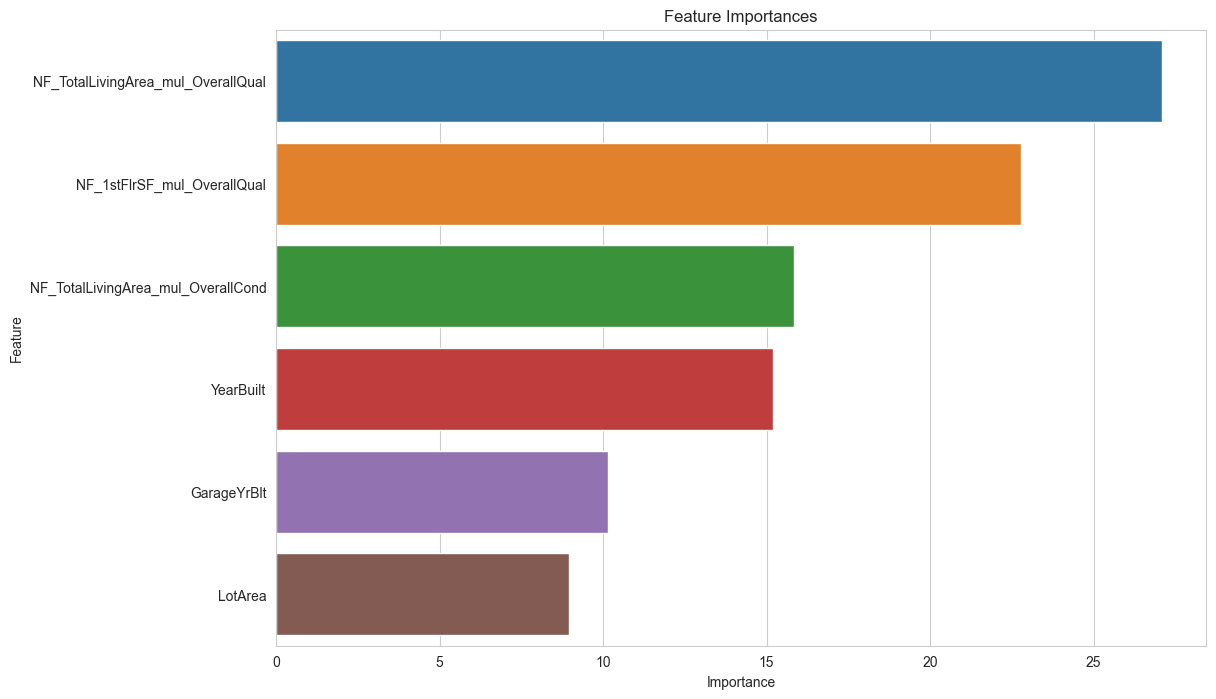

In [20]:
plot_feature_importance_absolute(best_pipeline_catboost)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Evaluates the performance of a regression model on both the training and test sets.
    
    Args:
        X_train (array-like): Training data features.
        y_train (array-like): Training data target values.
        X_test (array-like): Test data features.
        y_test (array-like): Test data target values.
        pipeline (Pipeline): The regression model pipeline to evaluate.
    """
    r2_train, mae_train, mse_train, rmse_train, msle_train = regression_evaluation(X_train, y_train, pipeline)
    r2_test, mae_test, mse_test, rmse_test, msle_test = regression_evaluation(X_test, y_test, pipeline)
    return (r2_train, mae_train, mse_train, rmse_train, msle_train), (r2_test, mae_test, mse_test, rmse_test, msle_test)


def regression_evaluation(X, y, pipeline):
    """
    Evaluates a regression model on a given dataset and prints key metrics.
    
    Args:
        X (array-like): Data features.
        y (array-like): Data target values.
        pipeline (Pipeline): The regression model pipeline to evaluate.
    """
    prediction = pipeline.predict(X)
    r2 = r2_score(y, prediction)
    mae = mean_absolute_error(y, prediction)
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(y, prediction)

    return r2, mae, mse, rmse, msle


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    """
    Plots actual vs predicted values for both training and test sets.
    
    Args:
        X_train (array-like): Training data features.
        y_train (array-like): Training data target values.
        X_test (array-like): Test data features.
        y_test (array-like): Test data target values.
        pipeline (Pipeline): The regression model pipeline to evaluate.
        alpha_scatter (float): Transparency of the scatter plot points.
    """
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    # Train set evaluation
    r2_train, mae_train, mse_train, rmse_train, msle_train = regression_evaluation(X_train, y_train, pipeline)
    # Test set evaluation
    r2_test, mae_test, mse_test, rmse_test, msle_test = regression_evaluation(X_test, y_test, pipeline)

    # Train plot: Actual vs Predicted
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0, 0], color='blue')
    axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    axes[0, 0].set_xlabel("Actual Values")
    axes[0, 0].set_ylabel("Predictions")
    axes[0, 0].set_title("Train Set: Actual vs Predicted")
    train_metrics_text = (f'R2: {round(r2_train, 3)}\n'
                          f'MAE: {round(mae_train, 3)}\n'
                          f'MSE: {round(mse_train, 3)}\n'
                          f'RMSE: {round(rmse_train, 3)}\n'
                          f'MSLE: {round(msle_train, 3)}')
    axes[0, 0].text(0.05, 0.95, train_metrics_text, transform=axes[0, 0].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

    # Test plot: Actual vs Predicted
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[0, 1], color='green')
    axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0, 1].set_xlabel("Actual Values")
    axes[0, 1].set_ylabel("Predictions")
    axes[0, 1].set_title("Test Set: Actual vs Predicted")
    test_metrics_text = (f'R2: {round(r2_test, 3)}\n'
                         f'MAE: {round(mae_test, 3)}\n'
                         f'MSE: {round(mse_test, 3)}\n'
                         f'RMSE: {round(rmse_test, 3)}\n'
                         f'MSLE: {round(msle_test, 3)}')
    axes[0, 1].text(0.05, 0.95, test_metrics_text, transform=axes[0, 1].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

    # Residuals plot: Train
    residuals_train = y_train - pred_train
    sns.scatterplot(x=pred_train, y=residuals_train, alpha=alpha_scatter, ax=axes[1, 0], color='blue')
    axes[1, 0].axhline(0, color='r', linestyle='--')
    axes[1, 0].set_xlabel("Predictions")
    axes[1, 0].set_ylabel("Residuals")
    axes[1, 0].set_title("Train Set: Residuals")

    # Residuals plot: Test
    residuals_test = y_test - pred_test
    sns.scatterplot(x=pred_test, y=residuals_test, alpha=alpha_scatter, ax=axes[1, 1], color='green')
    axes[1, 1].axhline(0, color='r', linestyle='--')
    axes[1, 1].set_xlabel("Predictions")
    axes[1, 1].set_ylabel("Residuals")
    axes[1, 1].set_title("Test Set: Residuals")

    # Error distribution plot: Train
    sns.histplot(residuals_train, kde=True, ax=axes[1, 2], color='blue')
    axes[1, 2].set_xlabel("Residuals")
    axes[1, 2].set_ylabel("Frequency")
    axes[1, 2].set_title("Train Set: Error Distribution")

    # Error distribution plot: Test
    sns.histplot(residuals_test, kde=True, ax=axes[0, 2], color='green')
    axes[0, 2].set_xlabel("Residuals")
    axes[0, 2].set_ylabel("Frequency")
    axes[0, 2].set_title("Test Set: Error Distribution")

    plt.tight_layout()
    plt.show()

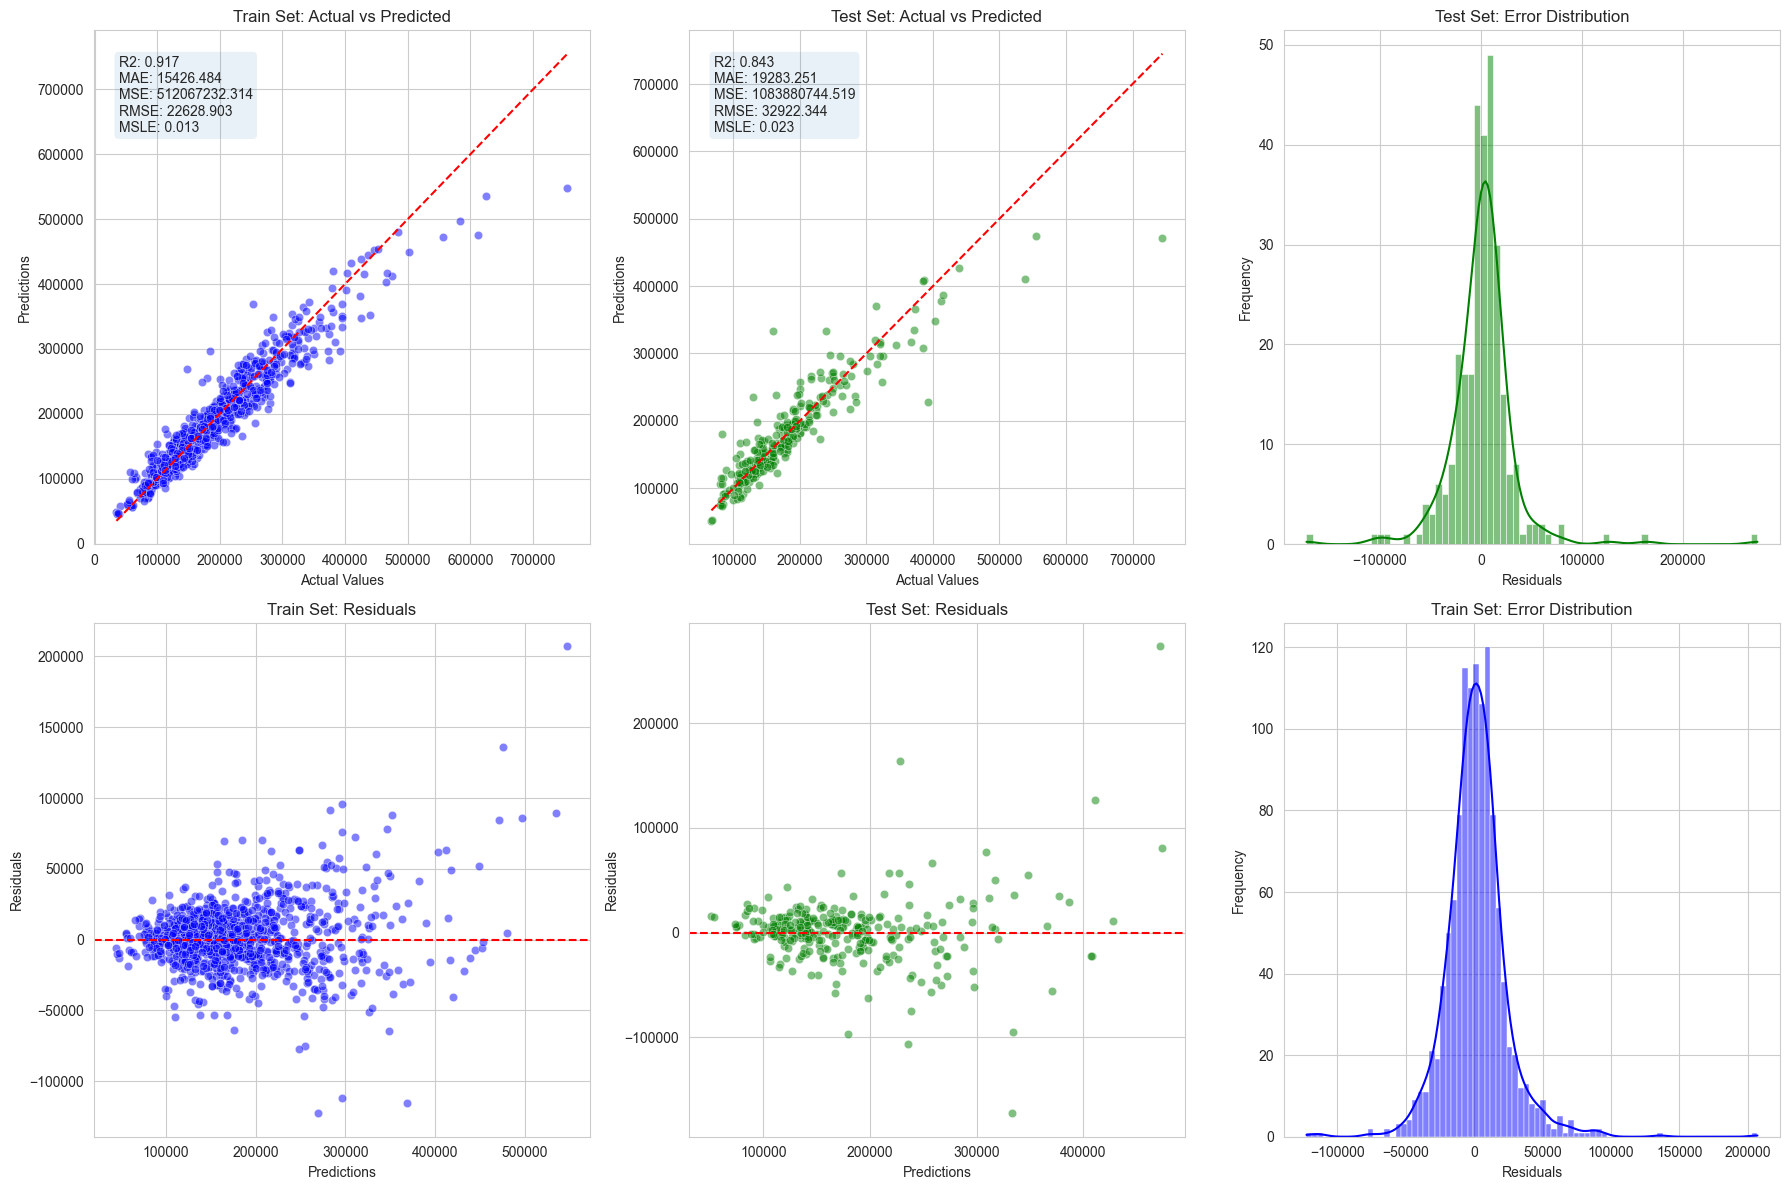

In [22]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_catboost)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_catboost)

### Saving current pipeline

We will save current pipeline in outputs/ml_pipeline/predict_saleprice.pkl

In [23]:
import joblib

joblib.dump(value=best_pipeline_catboost, filename='outputs/ml_pipeline/predict_sale_price.pkl')

['outputs/ml_pipeline/predict_sale_price.pkl']

## Business Requirements

As model is complete and validated, we have to satisfy business requirements

### Business Requirement 1 - Data Visualisation and Correlation Study

We already Have Feature Importance from our model, now we will create plots of Correlation between Given Features and SalePrice

In [24]:
df_transformed = pre_feature_transformations.fit_transform(X_train)

In [25]:
df_transformed

,YearBuilt,GarageYrBlt,LotArea,NF_1stFlrSF_mul_OverallQual,NF_TotalLivingArea_mul_OverallCond,NF_TotalLivingArea_mul_OverallQual
618,2007,2007,11694,16452,18280,32904
870,1962,1962,6600,4470,8940,8940
92,1921,1921,13360,4820,13496,9640
817,2002,2002,13265,13512,16890,27024
302,2001,2001,13704,10787,15410,21574
...,...,...,...,...,...,...
763,1999,1999,9430,10144,23650,37840
835,1950,1996,9600,4268,14938,8536
1216,1978,1978,8930,7908,19020,22824
559,2003,2003,3196,10899,15570,21798


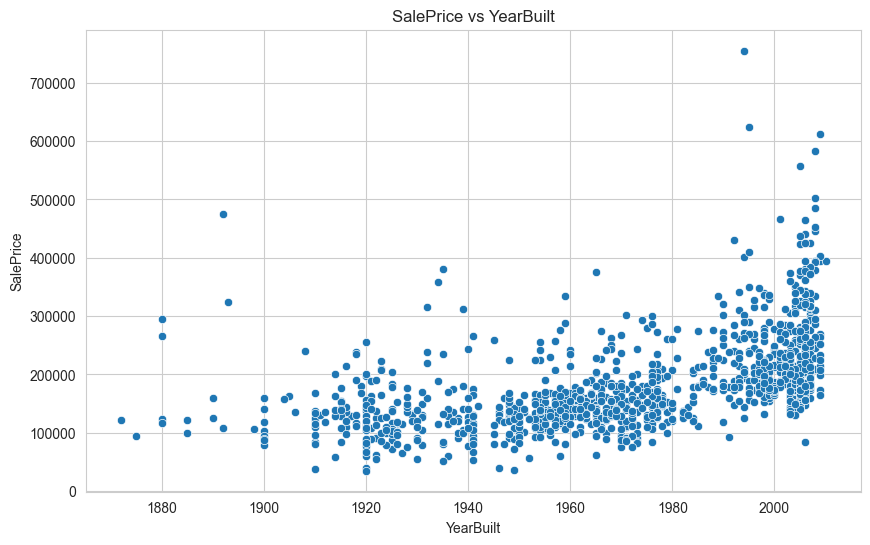

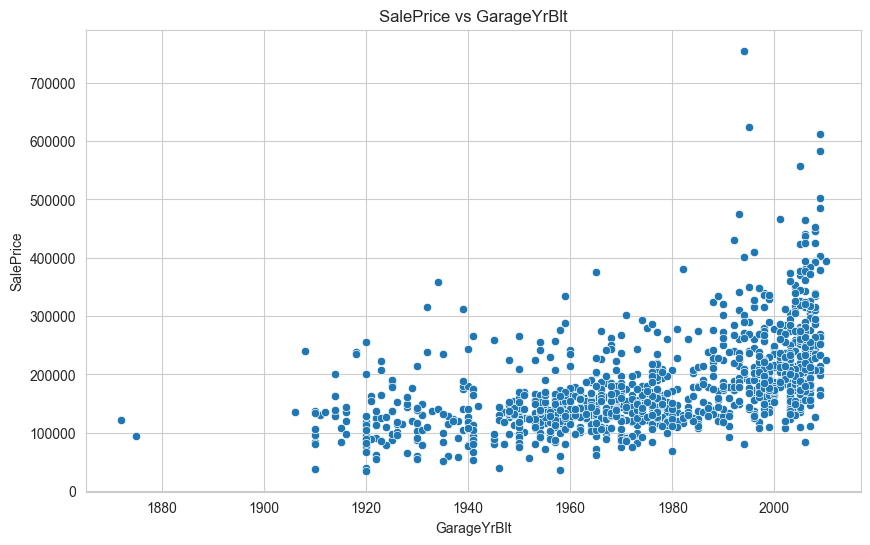

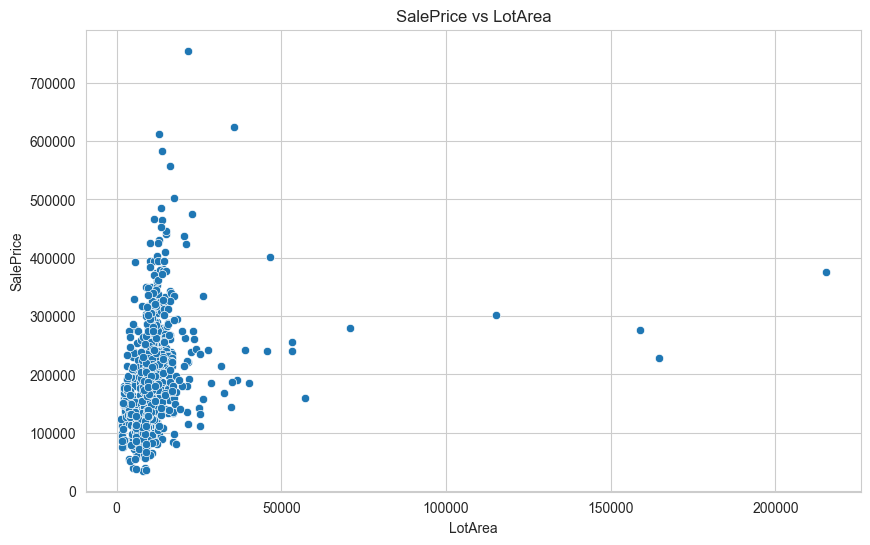

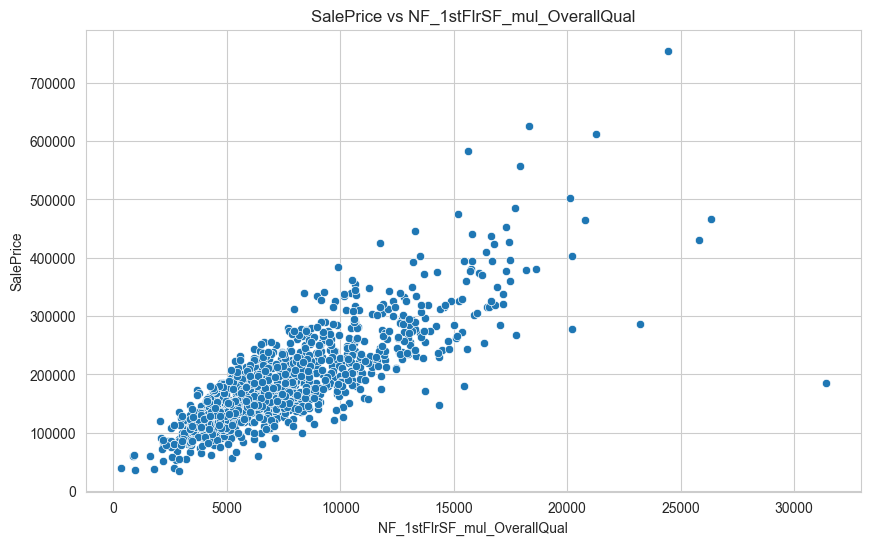

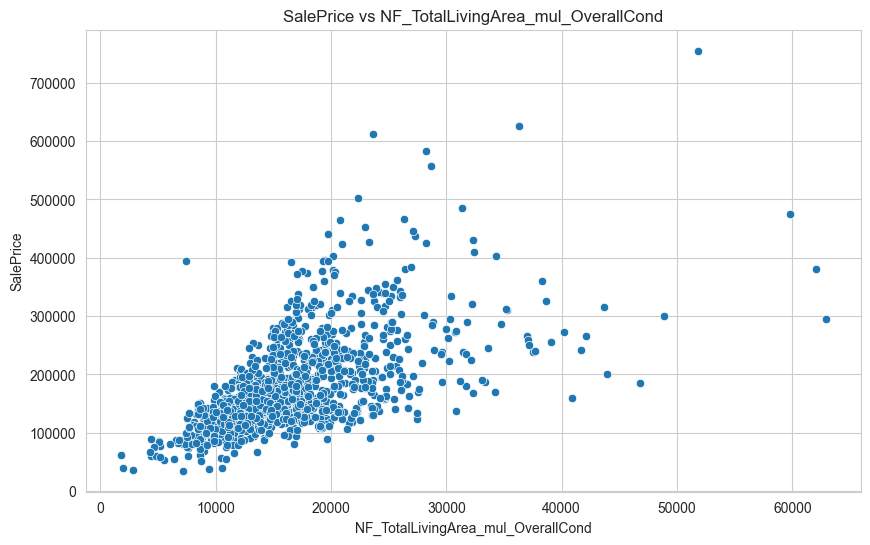

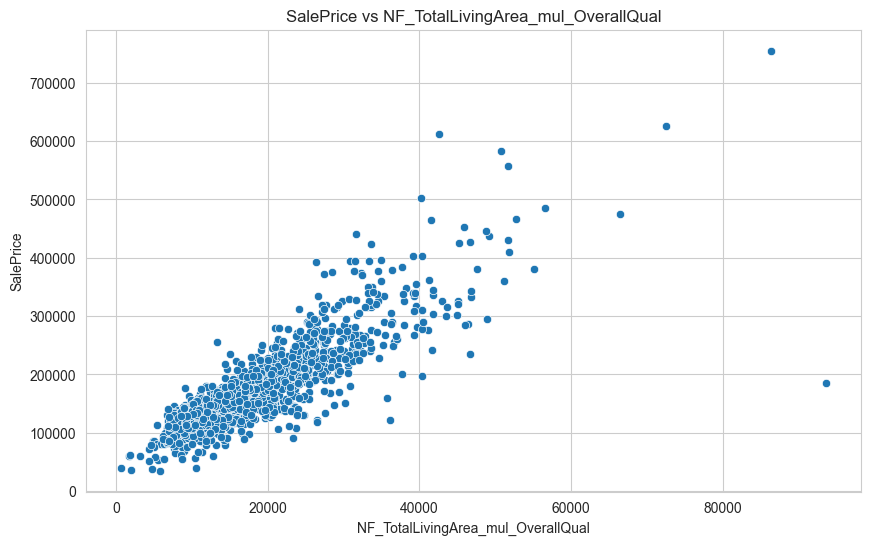

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical features to plot
numerical_features = df_transformed.columns.tolist()

# Create scatter plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_transformed[feature], y=y_train)
    plt.title(f'SalePrice vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

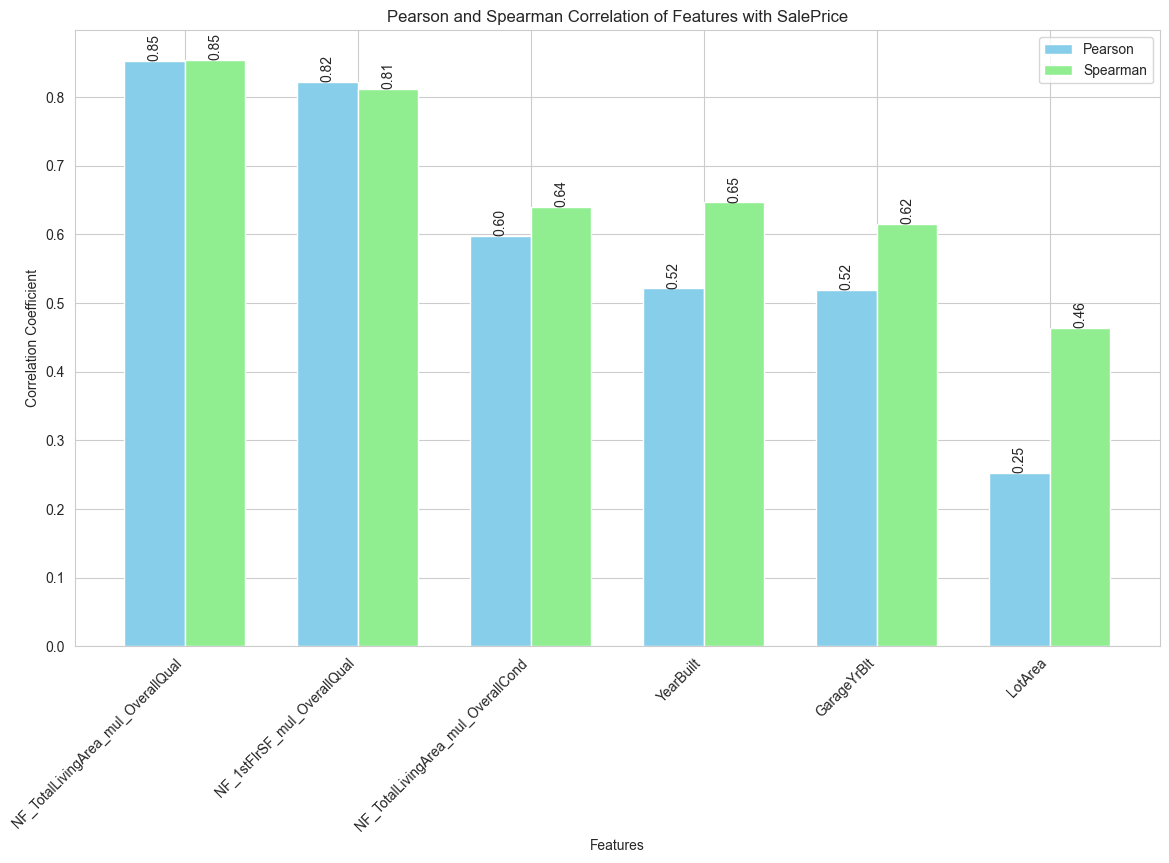

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_transformed and y_train are already defined

# Compute the Pearson correlation of each feature with the target variable
pearson_corr = df_transformed.apply(lambda x: x.corr(y_train, method='pearson'))

# Compute the Spearman correlation of each feature with the target variable
spearman_corr = df_transformed.apply(lambda x: x.corr(y_train, method='spearman'))

# Combine the correlations into a DataFrame
correlation_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})

# Plot the combined correlations
correlation_df_sorted = correlation_df.sort_values(by='Pearson', ascending=False)

# Create a grouped bar plot
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(correlation_df_sorted))

bars1 = plt.bar(index, correlation_df_sorted['Pearson'], bar_width, label='Pearson', color='skyblue')
bars2 = plt.bar(index + bar_width, correlation_df_sorted['Spearman'], bar_width, label='Spearman', color='lightgreen')

plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.title('Pearson and Spearman Correlation of Features with SalePrice')
plt.xticks(index + bar_width / 2, correlation_df_sorted.index, rotation=45, ha='right')
plt.legend()

# Add the correlation coefficients on top of each bar
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)

plt.show()


## Predicting SalePrice For customer

In [28]:
df_predict = pd.read_csv("outputs/datasets/collection/InheritedHouses.csv")

In [29]:
df_predict = df_predict[['YearBuilt', 'GarageYrBlt', 'LotArea', '1stFlrSF', '2ndFlrSF',
                         'GrLivArea', 'OverallQual', 'OverallCond']]

In [30]:
predictions = best_pipeline_catboost.predict(df_predict)

In [31]:
df_predict.loc[:,'SalePrice'] = predictions.round().astype(int)

In [32]:
df_predict

,YearBuilt,GarageYrBlt,LotArea,1stFlrSF,2ndFlrSF,GrLivArea,OverallQual,OverallCond,SalePrice
0,1961,1961.0,11622,896,0,896,5,6,124293
1,1958,1958.0,14267,1329,0,1329,6,6,162743
2,1997,1997.0,13830,928,701,1629,5,5,170909
3,1998,1998.0,9978,926,678,1604,6,6,187232


In [33]:
from tabulate import tabulate

markdown_table = tabulate(df_predict, headers='keys', tablefmt='pipe', showindex=False)

In [34]:
print(markdown_table)

|   YearBuilt |   GarageYrBlt |   LotArea |   1stFlrSF |   2ndFlrSF |   GrLivArea |   OverallQual |   OverallCond |   SalePrice |
|------------:|--------------:|----------:|-----------:|-----------:|------------:|--------------:|--------------:|------------:|
|        1961 |          1961 |     11622 |        896 |          0 |         896 |             5 |             6 |      124293 |
|        1958 |          1958 |     14267 |       1329 |          0 |        1329 |             6 |             6 |      162743 |
|        1997 |          1997 |     13830 |        928 |        701 |        1629 |             5 |             5 |      170909 |
|        1998 |          1998 |      9978 |        926 |        678 |        1604 |             6 |             6 |      187232 |
